# **A Complete Implementation of Transformer Architecture from Scratch using PyTorch.**

### **A clean and complete reproduction of the "Attention is All You Need" paper using PyTorch, built from the ground up without relying on high-level libraries like torch.nn.Transformer. Includes Multi-Head Attention, Positional Encoding, Encoder-Decoder stack, and more.**

# **Architecture**

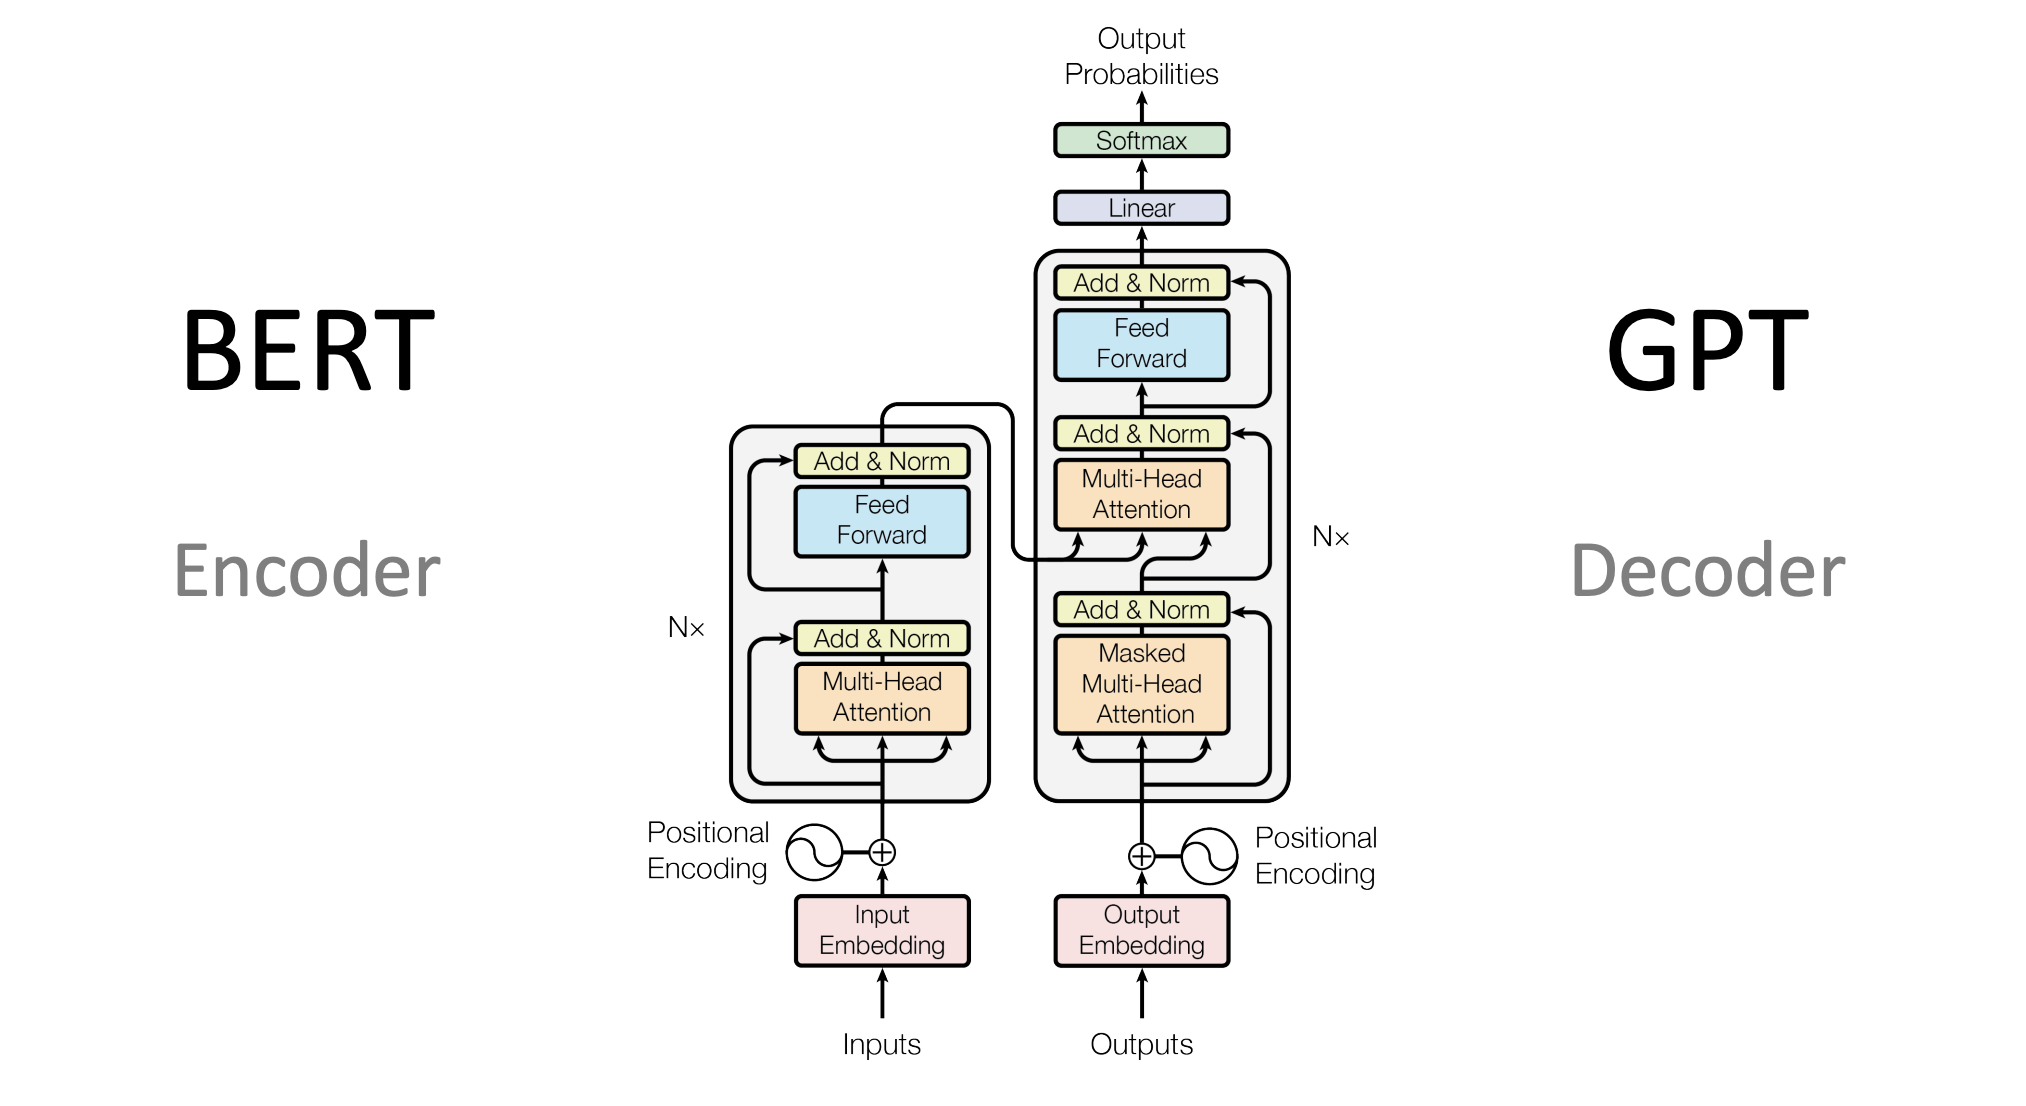

In [2]:
from IPython.display import Image
Image('/content/transformers.png')

**Config.py**

In [1]:
from config import *

In [7]:
D_MODEL = 512 # Dimension of input token representation - embeddings
VOCAB_SIZE = 10000 # Number of tokens in vocabulary
MAX_SEQ_LEN = 128 # Maximum Sequence Length of Input Sequence (increased for text classification)
NUM_LAYERS = 6 # Number of encoder layers (removed decoder for classification)
ATTN_DROPOUT = 0.1 # Quantify the dropout of how much in attention
EPS = 1e-6 # A small value to avoid zero division error while normalization
FF_DROPOUT = 0.1 # How much dropout in FFN
NUM_HEADS = 8 # Number of attention heads
RES_DROPOUT = 0.1 # Dropout for residual connection
TOKENIZER_PATH = "tokenizer.json" # Tokenizer path
DATASET_ID = "dair-ai/emotion" # Dataset ID from HuggingFace
SRC_CLN_NAME = "text" # Source column name
TGT_CLN_NAME = "label" # Target column name
NUM_CLASSES = 6 # Number of emotion classes (sadness, joy, love, anger, fear, surprise)
BATCH_SIZE = 32 # Number of samples per batch
LR = 2e-5 # Learning Rate for optimizer
NUM_EPOCHS = 10 # Number of training epochs
MODEL_SAVE_PATH = "transformer_emotion_classifier" # Model save path

# **Input Embedding**

In [8]:
import torch
import torch.nn as nn
from config import *
import math

class TokenEmbeddings(nn.Module):

    def __init__(self, d_model: int, vocab_size: int) -> None:

        '''
        Computes the token embeddings for input tokens

        Args:
        d_model - Input representation(Embedding) dimension
        vocab_size - Size of vocabulary

        Returns:
        token_embedding - Embedding of Input Tokens
        '''

        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(
                                        num_embeddings=vocab_size,
                                        embedding_dim=d_model
                                    ) # Shape: (vocab_size, embed_dim)

    def forward(self, x: torch.Tensor): # Input - (bs, seq_len) -> Output: bs, seq_len, d_model
        token_embedding = self.embedding(x) * math.sqrt(self.d_model) # Scale embeddings
        return token_embedding

In [9]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout_p: float) -> None:

        '''
        Computes the Positional Encoding for the Input Tokens positions

        Args:
        d_model - Embedding dimension
        seq_len - Number of tokens in the input sequence
        dropout - Dropout value

        Returns:
        pos_encoding - Encoded position values
        '''

        super().__init__()

        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout_p = dropout_p

        self.dropout = nn.Dropout(self.dropout_p) # Dropout layer
        position_encodings = torch.zeros(self.seq_len, self.d_model) # Shape: (seq_len, d_model)
        positions = torch.arange(0, self.seq_len, dtype=torch.float).unsqueeze(1) # Shape: (seq_len) -> (seq_len, 1)
        even_odd_i = torch.arange(0, self.d_model, 2).float() # 2i # Shape: (d_model/2)
        div_freqs_term = torch.pow(10000, even_odd_i/d_model) # 10000**2i/dmodel
        position_encodings[:, 0::2] = torch.sin(positions*div_freqs_term) # Shape: (seq_len, d_model)
        position_encodings[:, 1::2] = torch.cos(positions*div_freqs_term) # Shape: (seq_len, d_model)
        position_encodings = position_encodings.unsqueeze(0) # Shape: (1, seq_len, d_model)
        self.register_buffer('position_encodings', position_encodings) # to be a part of module state but not a parameter of module

    def forward(self, x: torch.Tensor):
        x = x + (self.position_encodings[:, :x.shape[1], :]).requires_grad_(False) # Adding positional encodings
        pos_encoding = self.dropout(x) # Addding dropout to the position embedded input
        return pos_encoding

In [10]:
class InputEmbeddings(nn.Module):

    def __init__(self):

        '''
        An Embedding module which will compute the input embedding by adding the token and position embedding of the input tokens

        Returns:
        inp_embedding - Input Embedding
        '''
        super().__init__()


        self.d_model = D_MODEL
        self.vocab_size = VOCAB_SIZE
        self.seq_len = MAX_SEQ_LEN
        self.dropout_p = FF_DROPOUT
        self.token_embedding = TokenEmbeddings(self.d_model, self.vocab_size)
        self.positional_encoding = PositionalEncoding(self.d_model, self.seq_len, self.dropout_p)

    def forward(self, x: torch.Tensor):

        token_embed_x = self.token_embedding(x)
        inp_embedding = self.positional_encoding(token_embed_x)
        return inp_embedding

# **Multi-Head Attention**

In [11]:
import torch.nn as nn
import math
import torch

class MultiHeadAttention(nn.Module):

    def __init__(self, d_model: int, num_heads: int, attn_dropout: float) -> None:

        '''
        Computes self attention by multiplying each token against every other token in a dot product manner resulting in a relationship of one token against every other tokens or vice versa showing impact of each token which helps to focus where it is needed improving the attention of the architecture.
        In this we use Self Attention as stated in the paper and compute it over multiple heads

        Args:
        d_model: Embedding dimension
        num_heads: Number of attention heads
        attn_dropout: Dropout probability for attention

        Returns:
        attn_out: Attention output value
        '''
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.num_heads = num_heads # Number of heads
        self.head_dim = d_model // num_heads # Dimension of vector seen by each head
        self.wq = nn.Linear(d_model, d_model, bias=False) # Wq -> Query
        self.wk = nn.Linear(d_model, d_model, bias=False) # Wk -> Key
        self.wv = nn.Linear(d_model, d_model, bias=False) # Wv -> Value
        self.wo = nn.Linear(d_model, d_model, bias=False) # Wo -> Output projection
        self.dropout = nn.Dropout(attn_dropout)

    def attention_calculation(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor):

        '''
        Function to calculate the attention by using Scaled Dot Product Attention

        attn(q,k,v) = softmax(q.k.T/sqrt(d_model)).V

        Args:
        query: query weights tensor
        key: key weights tensor
        value: value weights tensor
        mask: attention_mask to indicate if the calculation needs to be performed on a given token. For PAD token ignoring and autoregressive while cross attention
        dropout: attention dropout probability
        '''

        # (bs, num_heads, seq_len, head_dim) --> (bs, num_heads, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if mask is not None:
            # A very low (indicating -inf) to the positions where mask == 0 so that in softmax it becomes 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (bs, num_heads, seq_len, seq_len) # Apply softmax

        if self.dropout is not None:
            attention_scores = self.dropout(attention_scores)

        # (bs, h, seq_len, seq_len) --> (bs, h, seq_len, head_dim)
        return (attention_scores @ value), attention_scores

    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, attn_mask: torch.Tensor):

        query = self.wq(q) # (bs, seq_len, d_model)
        key = self.wk(k) # (bs, seq_len, d_model)
        value = self.wv(v) # (bs, seq_len, d_model)

        # d_model = num_heads*head_dim
        # (bs, seq_len, d_model) --> (bs, seq_len, num_heads, head_dim) --> (bs, num_heads, seq_len, head_dim)
        query = query.view(query.shape[0], query.shape[1], self.num_heads, self.head_dim).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.num_heads, self.head_dim).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.num_heads, self.head_dim).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = self.attention_calculation(query, key, value, attn_mask)

        # Concatenate all the heads together
        # (bs, num_heads, seq_len, head_dim) --> (bs, seq_len, num_heads, head_dim) --> (bs, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.d_model)

        # Learn all the features concatenated by output projection layer since all heads are concatenated
        # (bs, seq_len, d_model)
        attn_out = self.wo(x)
        return attn_out

# **Layer Normalization and Residual Connection**

In [12]:
import torch.nn as nn
import torch

class LayerNorm(nn.Module):
    def __init__(self, d_model: int, eps: float) -> None:
        '''
        Normalizes the values layerwise by the formula: X-mean/(std + eps)
        Here eps -> epsilon is a very small value preventing zero division.
        Here also two other parameters known as alpha and beta are introduced where alpha is multiplicative and beta is additive so that it introduces some deviations in the data creating some variety since by this normalization all values will fall under 0 to 1.
        alpha and beta are learnable parameters
        Returns:
        layer_norm_out - Normalized layer value output
        '''
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))

    def forward(self, x: torch.Tensor):
        mean = x.mean(dim=-1, keepdim=True) # Finding mean across the last dimension while retaining the dimension
        std = x.std(dim=-1, keepdim=True) # Finding std across the last dimension while retaining the dimension
        x_normalized = (x - mean)/(std + self.eps) # X - mean / std + eps
        layer_norm_out = self.alpha * x_normalized + self.beta # Variance creation by alpha * x_normalized + beta
        return layer_norm_out


In [19]:
class ResidualConnection(nn.Module):
    def __init__(self, d_model: int, res_dropout: float):
        '''
        In the paper the Add and Layer Norm is handled by this Residual connection layer where the inputs is passed to a layer and that output is added with the input and is normalized at the layer level
        x = LayerNorm(x + sublayer(x))
        Args:
        res_dropout - residual dropout probability
        Returns:
        add_layer_norm_out  - Add and Layer Norm output
        '''
        super().__init__()
        self.dropout_layer = nn.Dropout(res_dropout)
        self.layer_norm_layer = LayerNorm(d_model, 1e-6)

    def forward(self, x, sublayer):
        sublayer_out = self.dropout_layer(sublayer(self.layer_norm_layer(x)))
        add_layer_norm_out = x + sublayer_out
        return add_layer_norm_out

# **Feed Forward NN**

In [13]:
import torch.nn as nn
import torch

class FeedForward(nn.Module):
    def __init__(self, d_model: int, ff_dropout: float) -> None:
        '''
        A FeedForward Block with two linear layers along with a dropout in it. Here the dimensions would be involving d_model and d_ff which according to the paper is four times the d_model and is the inner dimension

        Args:
        d_model - Embedding dimension
        ff_dropout - Dropout value

        Returns:
        ff_out - Feed Forward Block Output'''
        super().__init__()
        self.d_model = d_model
        self.ff_dropout = ff_dropout
        self.d_ff = self.d_model * 4
        self.linear_1 = nn.Linear(self.d_model, self.d_ff) # Linear layer 1
        self.linear_2 = nn.Linear(self.d_ff, self.d_model) # Linear Layer 2
        self.ff_dropout_layer = nn.Dropout(self.ff_dropout) # Dropout layer with p = ff_dropout

    def forward(self, x: torch.Tensor):
        linear_1_out = self.linear_1(x) # Linear layer 1 out # Shape: bs,seq_len, d_ff
        linear_1_out = torch.relu(linear_1_out) # Applying ReLU activation function
        linear_1_out = self.ff_dropout_layer(linear_1_out) # Applying Dropout
        ff_out = self.linear_2(linear_1_out) # Linear layer 2 -> FF Block output # Shape: bs,seq_len, d_model
        return ff_out

# **Encoder Block**

In [14]:
from config import *
#from attention import MultiHeadAttention
#from ffn import FeedForward
#from layer_norm import ResidualConnection, LayerNorm
import torch.nn as nn
import torch

class EncoderBlock(nn.Module):
    def __init__(self):
        '''
        A Single Encoder block that can be stacked multiple times to form the encoder which uses two main blocks: Self Attention + Feed Forward connected with some Residual Connections
        Returns:
        enc_block_out - Encoder Block Output
        '''
        super().__init__()
        self.d_model = D_MODEL # Embedding dimension
        self.num_heads = NUM_HEADS # Number of heads
        self.attn_dropout = ATTN_DROPOUT # Attention dropout value
        self.ff_dropout = FF_DROPOUT # Feed forward dropout value
        self.res_dropout = RES_DROPOUT # Residual connection dropout value
        self.self_attention = MultiHeadAttention(self.d_model, self.num_heads, self.attn_dropout) # Attention layer
        self.feed_forward = FeedForward(self.d_model, self.ff_dropout) # Feedforward layer
        self.res_connection1 = ResidualConnection(self.d_model, self.res_dropout) # Residual connection layer1
        self.res_connection2 = ResidualConnection(self.d_model, self.res_dropout) # Residual connection layer2

    def forward(self, x: torch.Tensor, src_attn_mask: torch.Tensor):
        attn_out = self.res_connection1(x, lambda x: self.self_attention(x, x, x, src_attn_mask)) # Attention and Normalized output
        enc_block_out = self.res_connection2(attn_out, self.feed_forward) # Feed Forward output normalized and produces encoder output
        return enc_block_out

class Encoder(nn.Module):
    def __init__(self, d_model: int, num_layers: int):
        '''
        Transformer encoder which has a stack of encoder blocks joined together

        Args:
        d_model: Embedding_dimension
        num_layers: Number of layers in the stack
        Returns:
        encoder_out: Encoder output
        '''
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock() for _ in range(num_layers)])
        self.layer_norm = LayerNorm(d_model, EPS)

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor):
        for layer in self.layers:
            x = layer(x, attn_mask)
        encoder_out = self.layer_norm(x)
        return encoder_out

# **Decoder Block**

In [15]:
#from config import *
#from attention import MultiHeadAttention
#from ffn import FeedForward
#from layer_norm import ResidualConnection, LayerNorm
import torch.nn as nn
import torch

class DecoderBlock(nn.Module):

    def __init__(self):

        '''
        A Single Decoder block that can be stacked multiple times to form the decoder which uses three main blocks: Self Attention, Cross Attention, Feed Forward connected with some Residual Connections

        Returns:
        dec_block_out - Decoder Block Output
        '''
        super().__init__()
        self.d_model = D_MODEL # Embedding dimension
        self.num_heads = NUM_HEADS # Number of heads
        self.attn_dropout = ATTN_DROPOUT # Attention dropout value
        self.ff_dropout = FF_DROPOUT # Feed forward dropout value
        self.res_dropout = RES_DROPOUT # Residual connection dropout value
        self.self_attention = MultiHeadAttention(self.d_model, self.num_heads, self.attn_dropout) # Self Attention layer
        self.cross_attention = MultiHeadAttention(self.d_model, self.num_heads, self.attn_dropout) # Cross Attention
        self.feed_forward = FeedForward(self.d_model, self.ff_dropout) # Feedforward layer
        self.res_connection1 = ResidualConnection(self.d_model, self.res_dropout) # Residual connection layer1
        self.res_connection2 = ResidualConnection(self.d_model, self.res_dropout) # Residual connection layer2
        self.res_connection3 = ResidualConnection(self.d_model, self.res_dropout) # Residual connection layer2

    def forward(self, x: torch.Tensor, encoder_out: torch.Tensor, src_attn_mask: torch.Tensor, tgt_attn_mask: torch.Tensor):
        self_attn_out = self.res_connection1(x, lambda x: self.self_attention(x, x, x, tgt_attn_mask)) # Self Attention and Normalized output
        cross_attn_out = self.res_connection2(self_attn_out, lambda self_attn_out: self.cross_attention(self_attn_out, encoder_out, encoder_out, src_attn_mask)) # Cross Attention and Normalized output
        dec_block_out = self.res_connection3(cross_attn_out, self.feed_forward) # Feed Forward output normalized and produces decoder output
        return dec_block_out

In [16]:
class Decoder(nn.Module):

    def __init__(self, d_model: int, num_layers: int):

        '''
        Transformer decoder which has a stack of decoder blocks joined together

        Args:
        d_model: Embedding_dimension
        num_layers: Number of layers in the stack

        Returns:
        decoder_out: Decoder output
        '''
        super().__init__()
        self.layers = nn.ModuleList([DecoderBlock() for _ in range(num_layers)])
        self.layer_norm = LayerNorm(d_model, EPS)

    def forward(self, x:torch.Tensor, encoder_out: torch.Tensor, src_attn_mask: torch.Tensor, tgt_attn_mask: torch.Tensor):

        for layer in self.layers:
            x = layer(x, encoder_out, src_attn_mask, tgt_attn_mask)
        decoder_out = self.layer_norm(x)
        return decoder_out

# **Transformer Block**

In [17]:
#from config import *
#from embedding import InputEmbeddings
#from encoder import Encoder
#from decoder import Decoder
import torch.nn as nn
import torch

class Transformer(nn.Module):

    def __init__(self):

        '''
        A Transformer model created from scratch

        Returns:
        transformer_out - Transformer model output
        '''

        super().__init__()

        self.d_model = D_MODEL
        self.num_layers = NUM_LAYERS
        self.vocab_size = VOCAB_SIZE
        self.inp_embedding = InputEmbeddings()
        self.encoder = Encoder(self.d_model, self.num_layers)
        self.decoder = Decoder(self.d_model, self.num_layers)
        self.projection = nn.Linear(self.d_model, self.vocab_size)

    def forward(self, src_x, src_attn_mask, tgt_x, tgt_attn_mask):

        src_embed = self.inp_embedding(src_x)
        tgt_embed = self.inp_embedding(tgt_x)
        encoder_out = self.encoder(src_embed, src_attn_mask)
        decoder_out = self.decoder(tgt_embed, encoder_out, src_attn_mask, tgt_attn_mask)
        transformer_out = self.projection(decoder_out)
        return transformer_out

# **Total Number of Parameters in Transformer**

In [21]:
trf= Transformer()
total_parameters = sum(p.numel() for p in trf.parameters())
print(f"Total number of parameters: {total_parameters:,}")

Total number of parameters: 54,353,680


In [22]:
transformer = Transformer()
transformer

Transformer(
  (inp_embedding): InputEmbeddings(
    (token_embedding): TokenEmbeddings(
      (embedding): Embedding(10000, 512)
    )
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderBlock(
        (self_attention): MultiHeadAttention(
          (wq): Linear(in_features=512, out_features=512, bias=False)
          (wk): Linear(in_features=512, out_features=512, bias=False)
          (wv): Linear(in_features=512, out_features=512, bias=False)
          (wo): Linear(in_features=512, out_features=512, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): FeedForward(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
          (ff_dropout_layer): Dropout(p=0.1, inplace=False)
        )
        (res_connection1): Residual